In [3]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sns
import csv
import sklearn
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.preprocessing import StandardScaler
import pylab as pl
import MLpipeline
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<h1 align="center">Homework 2 – Machine Learning Pipeline</h1> 
<h3 align="center">Elena Badillo Goicoechea </h3>


The purpose of this assigmnent is to build the first sketch of an increasingly flexible, general machine learning pipeline, while testing it with a working example where we will try to predict which persons will experience financial distress in the next two years, using other information about them as features.

## 1. Load Data

In this case, the original dataset is in csv format (of course, that can change in future projects, so the associated function covers some other possibilities).

In [4]:
df, df_dups = MLpipeline.load_data('', 'credit-data.csv', format_= 'csv', dups = True)

## 2. Data Exploration

As a necessary initial step before attempting to train a predictive model, we will get a grasp of the general structure of the dataset: its size, granularity, variable types, and some basic statistical properties. Moreover, after directly inspecting the data we can often gain (or lose) confidence in the quality information we have (e.g. negative salaries?). Finally, in further stages of the analysis it will likely be necessary to go back and revisit this findings, to see if it all makes sense (and why, or why not).

In [6]:
# 2.1
MLpipeline.overview(df,df_dups)

DATASET DIMENSIONS: 41016 rows, 13 columns
DUPLICATE ROWS:0


PersonID                                  int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
zipcode                                   int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

Sometimes the original __column names__ can be long or hard to read and manipulate, so it's better to change them:

In [8]:
MLpipeline.rename_cols(df, [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12], 
            ['per_id','ser_DLq2', 'rev_util', 'num_30_59_pastdue', 'debt_ratio','month_inc', 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 
             'num_60_89_pastdue', 'num_dep'])

In [9]:
# 2.2
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
per_id,41016.0,115800.154598,28112.723511,22.0,106539.750000,119901.500000,134698.250000,149999.0
ser_DLq2,41016.0,0.161400,0.367904,0.0,0.000000,0.000000,0.000000,1.0
rev_util,41016.0,6.375870,221.618950,0.0,0.034310,0.189730,0.667160,22000.0
age,41016.0,51.683489,14.746880,21.0,41.000000,51.000000,62.000000,109.0
zipcode,41016.0,60623.824166,11.984357,60601.0,60618.000000,60625.000000,60629.000000,60644.0
num_30_59_pastdue,41016.0,0.589233,5.205628,0.0,0.000000,0.000000,0.000000,98.0
debt_ratio,41016.0,331.458137,1296.109695,0.0,0.176375,0.369736,0.866471,106885.0
month_inc,33042.0,6578.995733,13446.825930,0.0,3333.000000,5250.000000,8055.750000,1794060.0
open_cred_lines,41016.0,8.403477,5.207324,0.0,5.000000,8.000000,11.000000,56.0
num_90_pastdue,41016.0,0.419592,5.190382,0.0,0.000000,0.000000,0.000000,98.0


### 2.2: Variable Distributions

Before choosing features and training a classifier, we'll explore some general patterns in the data, such as distributions, conditional distributions, and correlations among variables.

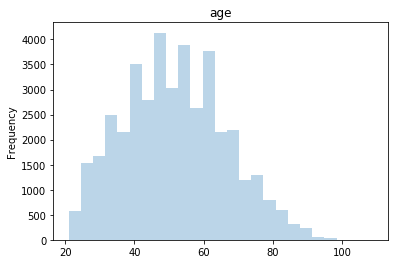

In [10]:
MLpipeline.plot_distrib(df, 'age')

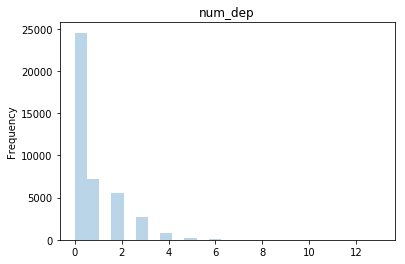

In [11]:
MLpipeline.plot_distrib(df, 'num_dep')

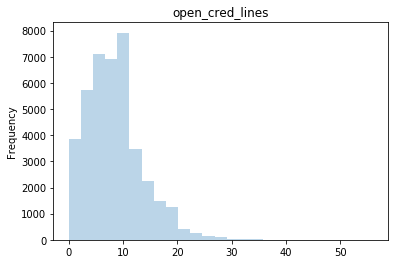

In [12]:
MLpipeline.plot_distrib(df, 'open_cred_lines')

(0, 15000)

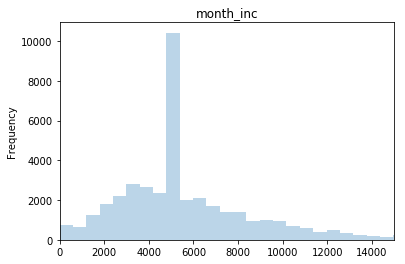

In [13]:
MLpipeline.plot_distrib(df, 'month_inc', bins = 3000)
plt.xlim([0,15000]) # we are manually capping income on 15,000 but as seen in the data summary, 
# there are some huge numbers in the right tail of the distribution that dramatically bias the distribution.

(-1, 15)

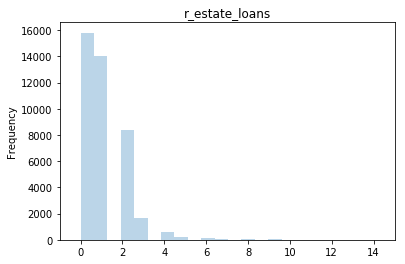

In [14]:
MLpipeline.plot_distrib(df, 'r_estate_loans', bins = 50)
plt.xlim([-1,15]) # same for real estate loans

It could be useful to compute these distributions in a more compact way, including all potentially interesting pairwise scatterplots:

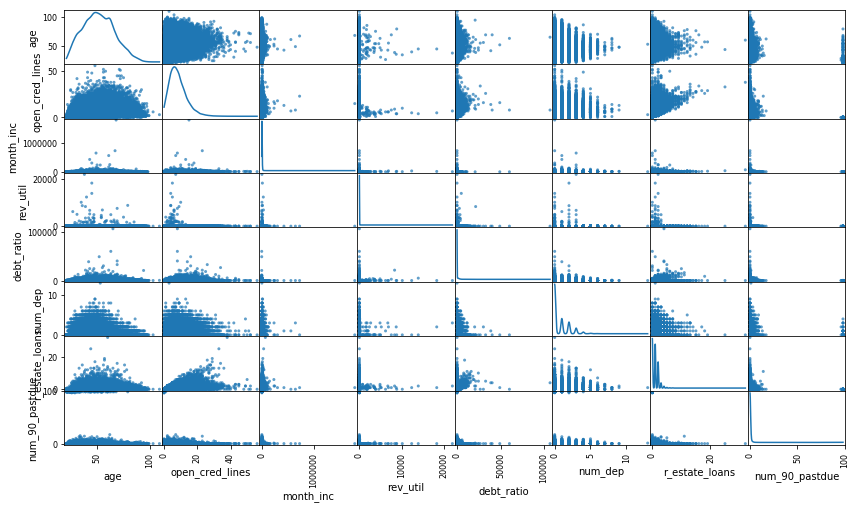

In [23]:
MLpipeline.multi_scatter(df, ['age', 'open_cred_lines', 'month_inc', 'rev_util', 'debt_ratio', 'num_dep',
                'r_estate_loans', 'num_90_pastdue'])

Our next step is to group basic aggregate stats of potential features by the cathegorical variable we want to predict -- delinquency (ser_DL_q2) in this case. That way we can spot some obvious relationships (if any):

In [15]:
MLpipeline.cond_stats(df, ['ser_DLq2','age' , 'rev_util'], 'ser_DLq2')

age                        rev_util                             
         amin       mean median amax     amin      mean    median     amax
ser_DLq2                                                                  
0          21  52.807419     52  109      0.0  6.821758  0.128939  22000.0
1          21  45.843807     45   99      0.0  4.059138  0.839318   8328.0

In the aggregate level, delinquents are younger than non-delinquents. Analyzing revolving credit utilization is not as straightforward because the mean is lower for delinquents but the median is dramatically higher. This suggests the presence of huge or heavily clustered outliers and, thus, a possible interesting feature for our classifying algorithm.

In [16]:
MLpipeline.cond_stats(df, ['ser_DLq2','debt_ratio','r_estate_loans' ], 'ser_DLq2')

debt_ratio                                 r_estate_loans            \
               amin        mean    median      amax           amin      mean   
ser_DLq2                                                                       
0               0.0  339.135574  0.359875  106885.0              0  1.014188   
1               0.0  291.567939  0.426882   38793.0              0  0.980816   

                      
         median amax  
ser_DLq2              
0             1   32  
1             1   25

The stats above are also interesting: debt ratio for non-delinquents is lower on average, but the median is clearly higher. This could be explained by outliers, something we will explore later.

In [17]:
MLpipeline.cond_stats(df, ['ser_DLq2','month_inc','num_dep' ], 'ser_DLq2')

month_inc                                 num_dep                   \
              amin         mean  median       amax    amin      mean median   
ser_DLq2                                                                      
0              0.0  6776.748201  5475.0  1794060.0     0.0  0.740771    0.0   
1              0.0  5594.740774  4500.0   250000.0     0.0  0.940452    0.0   

                
          amax  
ser_DLq2        
0         13.0  
1          7.0

This agrees with our basic intuition: less income and more financial dependants are, in the aggregate, associated to higher delinquency.

In [18]:
MLpipeline.cond_stats(df, ['ser_DLq2','num_60_89_pastdue','num_30_59_pastdue','num_90_pastdue' ], 'ser_DLq2')

num_60_89_pastdue                       num_30_59_pastdue            \
                      amin      mean median amax              amin      mean   
ser_DLq2                                                                       
0                        0  0.095156      0   98                 0  0.248197   
1                        0  1.807855      0   98                 0  2.361178   

                     num_90_pastdue                        
         median amax           amin      mean median amax  
ser_DLq2                                                   
0             0   98              0  0.101698      0   98  
1             0   98              0  2.071299      0   98

The number of days past due on payments looks like a promising predictor --especially num_90_pastdue, as the __relative average level__ between delinquents and non-delinquent levels is huge:

In [19]:
av_delinq = MLpipeline.cond_stats(df, ['ser_DLq2','num_60_89_pastdue','num_30_59_pastdue','num_90_pastdue' ], \
                      'ser_DLq2')
print('num_90_pastdue ratio: ' + str(av_delinq['num_90_pastdue', 'mean'][1] / av_delinq['num_90_pastdue', 'mean'][0]) + '\n' +
'num_60_89_pastdue ratio: ' + str(av_delinq['num_60_89_pastdue', 'mean'][1] / av_delinq['num_60_89_pastdue', 'mean'][0]) + '\n' +
'num_30_59_pastdue ratio: ' + str(av_delinq['num_30_59_pastdue', 'mean'][1] / av_delinq['num_30_59_pastdue', 'mean'][0]))
                              

num_90_pastdue ratio: 20.367182282840954
num_60_89_pastdue ratio: 18.998771787480283
num_30_59_pastdue ratio: 9.513305260520491


### 2.3 : Find outliers

As mentioned before, outliers can significantly affect averages and other common statistics we frequently used to analyze data (and mislead us if we just leave it there). Furthermore, they can themsleves convey important patterns in the data, so we want to be able to detect them automatically. Here we define outliers as larger-than-3.3 standard deviations from the mean (more sensible approaches are possible but this is intuitive).

In [20]:
vars_interest = ['rev_util', 'num_30_59_pastdue', 'debt_ratio','month_inc', 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 
             'num_60_89_pastdue', 'num_dep']

outliers = MLpipeline.find_outliers(df, vars_interest, 3.3)

In [21]:
for var, lst in outliers.items():
    print(str(var) +' : ' + str(len(lst)))

rev_util : 62
num_30_59_pastdue : 115
debt_ratio : 488
month_inc : 82
open_cred_lines : 323
num_90_pastdue : 115
r_estate_loans : 470
num_60_89_pastdue : 115
num_dep : 275


As previously suspected, debt ratio has a large number of outliers, which could certainly bias its average and "hide" its plausible relationship to delinquency status.

## 3. Pre-Processing

### 3.1: Count missing observations for each column

In [22]:
df.isnull().sum()

per_id                  0
ser_DLq2                0
rev_util                0
age                     0
zipcode                 0
num_30_59_pastdue       0
debt_ratio              0
month_inc            7974
open_cred_lines         0
num_90_pastdue          0
r_estate_loans          0
num_60_89_pastdue       0
num_dep              1037
dtype: int64

### 3.2:  Impute missing values

We could fill missing values for income and number of dependants using their respective sample means. However, averages are sensitive to outliers (of which we have a lot, as we saw before). Therefore, to be conservative we will use the __median__. Of course there are more sensible approaches, like using conditional mean or k-nearest neighboors to compute tailored estimates, but for the purposes of this exercise we will keep it simple.

In [23]:
df = MLpipeline.impute(df, method = 'simple')
df[['month_inc', 'num_dep']].isnull().sum()

month_inc    0
num_dep      0
dtype: int64

## 4. Generate Features/Predictors

### 4.1: Explore potential features

Scatterplots can be useful but they only show a part of the whole picture. They only reveal straightforward linear relationships (if any) between continuous variables, and they do so when data is not noisy. Sometimes it is also useful to group variables and explore their conditional distributions and pairwise correlations against the outcome variable.

,correlations w/ delinquency
ser_DLq2,1.000000
num_30_59_pastdue,0.149334
num_90_pastdue,0.139609
num_60_89_pastdue,0.121886
num_dep,0.066806
rev_util,-0.004586
r_estate_loans,-0.010641
debt_ratio,-0.013502
month_inc,-0.028426
open_cred_lines,-0.039898


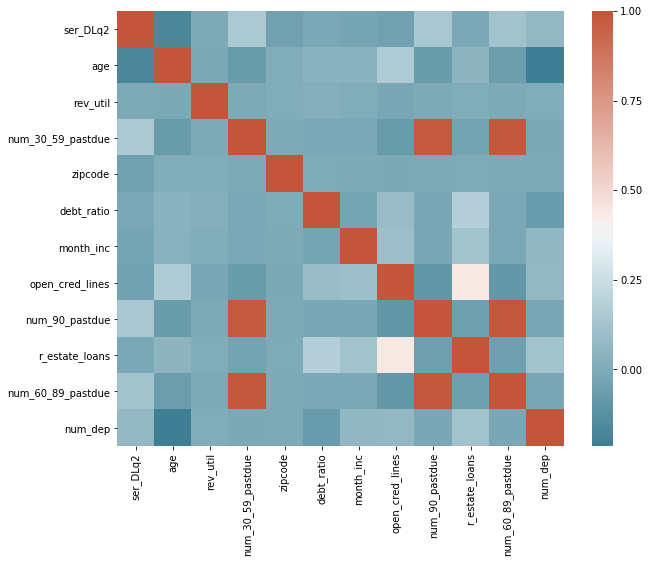

In [37]:
vars_interest = ['ser_DLq2', 'age', 'rev_util', 'num_30_59_pastdue', 'zipcode', 'debt_ratio','month_inc',\
                 'open_cred_lines', 'num_90_pastdue', 'r_estate_loans', 'num_60_89_pastdue', 'num_dep']
MLpipeline.top_corr(df, vars_interest, 'ser_DLq2')

From the table and the heatmap above we can see there are some clear positive __correlations__ among the three variables measuring number of times the person has been past due on payments, and between real-estate loans and open credit lines, and revolving utlization od credit. All of these are also positively correlated with the label (delinquency). Also, age is negatively related to the label.

### 4.2: Discretize Continuous Variables and Categorize Selected Features

Sometimes it is convenient or even necessary to turn continuous (or countable but taking too many values) variables into discrete ones by __cathegorizing__ them into buckets of increasing ranges. This allows us, for example, to easily analyze conditional distributions and time trends, and to spot the possible influence of outliers in the feature's distribution. Here we will take a simple approach, placing observations into equally spaced buckets and assigning them dummies.

In [114]:
df_dums = MLpipeline.categorize(df, ['age', 'open_cred_lines', 'month_inc', 'rev_util', 'debt_ratio',  'num_30_59_pastdue', 'num_dep',\
                'r_estate_loans', 'num_90_pastdue', 'num_60_89_pastdue'],\
           [15, 15, 15, 15, 15, 20, 15, 15, 20, 20])

In [115]:
df_dums.head()

,ser_DLq2,age_dum,open_cred_lines_dum,month_inc_dum,rev_util_dum,debt_ratio_dum,num_30_59_pastdue_dum,num_dep_dum,r_estate_loans_dum,num_90_pastdue_dum,num_60_89_pastdue_dum
0,0,5,0,0,14,3,0,0,0,0,0
1,0,8,1,14,8,0,0,0,0,0,0
2,0,5,1,4,0,0,0,0,0,0,0
3,0,5,3,10,13,0,0,0,1,0,0
4,0,4,1,11,0,0,0,2,0,0,0


### 4.3 Visualize features

<Figure size 432x288 with 0 Axes>

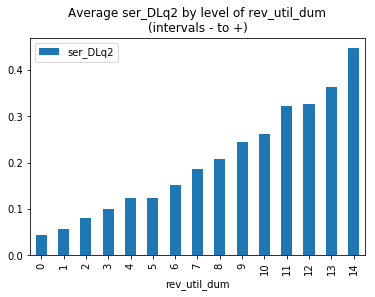

In [169]:
MLpipeline.plot_cond_mean(df_dums, 'rev_util_dum', 'ser_DLq2')

The pattern above is strikingly clear: higher levels of revolving credit utilization are clearly associated to delinquency.

<Figure size 432x288 with 0 Axes>

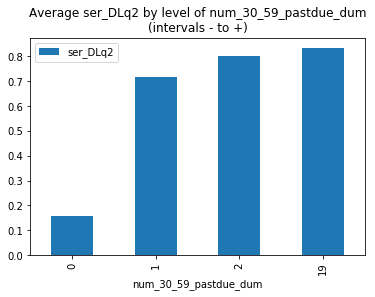

In [170]:
MLpipeline.plot_cond_mean(df_dums, 'num_30_59_pastdue_dum', 'ser_DLq2')

<Figure size 432x288 with 0 Axes>

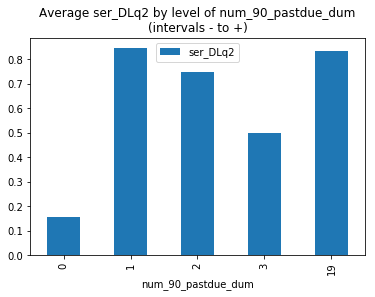

In [171]:
MLpipeline.plot_cond_mean(df_dums, 'num_90_pastdue_dum', 'ser_DLq2')

<Figure size 432x288 with 0 Axes>

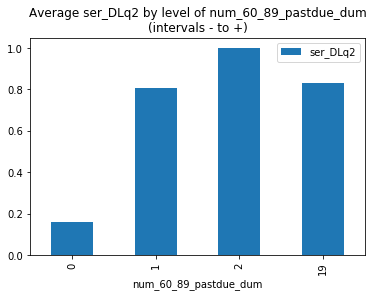

In [172]:
MLpipeline.plot_cond_mean(df_dums, 'num_60_89_pastdue_dum', 'ser_DLq2')  

<Figure size 432x288 with 0 Axes>

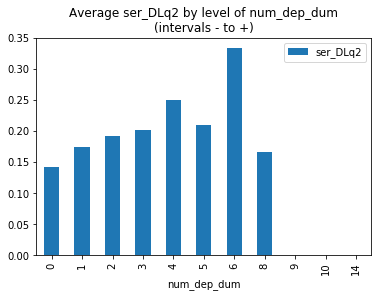

In [173]:
MLpipeline.plot_cond_mean(df_dums, 'num_dep_dum', 'ser_DLq2')  

<Figure size 432x288 with 0 Axes>

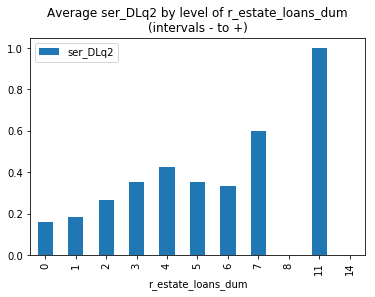

In [174]:
MLpipeline.plot_cond_mean(df_dums, 'r_estate_loans_dum', 'ser_DLq2')  

<Figure size 432x288 with 0 Axes>

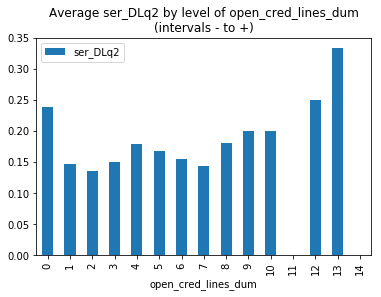

In [175]:
MLpipeline.plot_cond_mean(df_dums, 'open_cred_lines_dum', 'ser_DLq2')  

<Figure size 432x288 with 0 Axes>

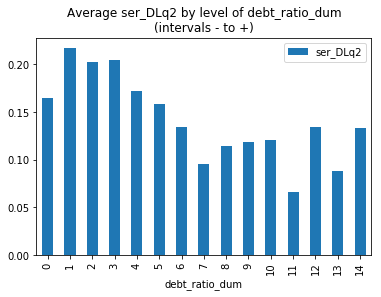

In [176]:
MLpipeline.plot_cond_mean(df_dums, 'debt_ratio_dum', 'ser_DLq2')  

<Figure size 432x288 with 0 Axes>

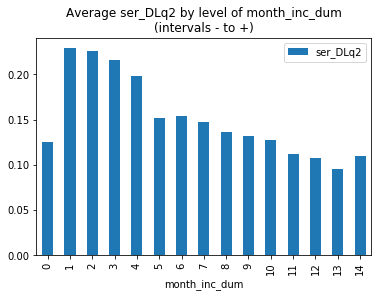

In [177]:
MLpipeline.plot_cond_mean(df_dums, 'month_inc_dum', 'ser_DLq2') 

<Figure size 432x288 with 0 Axes>

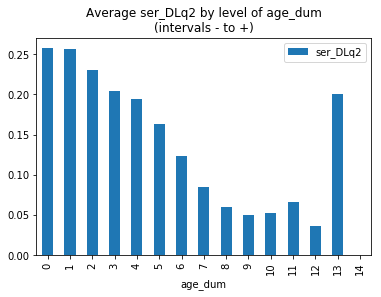

In [178]:
MLpipeline.plot_cond_mean(df_dums, 'age_dum', 'ser_DLq2')  

We can take a closer look at some of these __conditional distributions__ by fitting a kernel density to each level (here we can notice the usefulness of discretization):

In [136]:
df_dums2 = MLpipeline.categorize(df, ['age', 'month_inc', 'rev_util', 'debt_ratio'],\
           [8, 8, 8, 8])

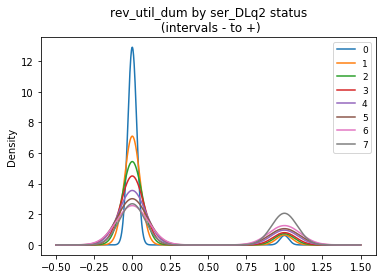

In [179]:
MLpipeline.plot_cond_dist(df_dums2, 'rev_util_dum', 'ser_DLq2')

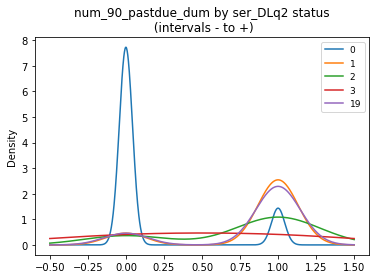

In [180]:
MLpipeline.plot_cond_dist(df_dums, 'num_90_pastdue_dum', 'ser_DLq2')

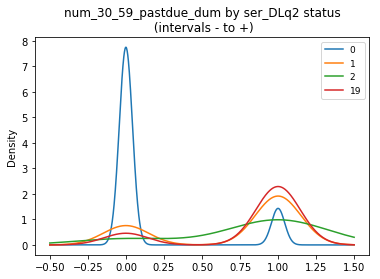

In [181]:
MLpipeline.plot_cond_dist(df_dums, 'num_30_59_pastdue_dum', 'ser_DLq2')

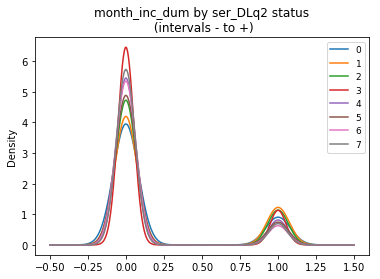

In [182]:
MLpipeline.plot_cond_dist(df_dums2, 'month_inc_dum', 'ser_DLq2')  

Having inspected the features potentially useful for predicting delinquency, we can take a more formal approach using a __random forest__ algorithm that will reveal the __importance of each feature__.

But first, let's __rescale__ income, so that standard deviations from the population mean are what matters in the predictions. In this particular case, doing this is important because monthly income is measured in units of significantly larger magnitude than the rest of the features, which could alter the results in non-sensical ways.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Scaled monthly income')

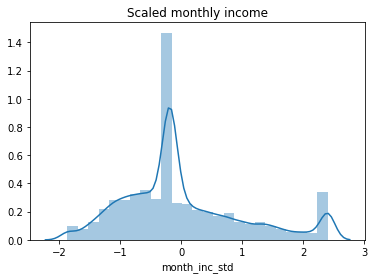

In [183]:
df['month_inc_std'] = MLpipeline.standarize(df['month_inc'])
sns.distplot(df['month_inc_std'], bins = 25)
plt.title('Scaled monthly income')

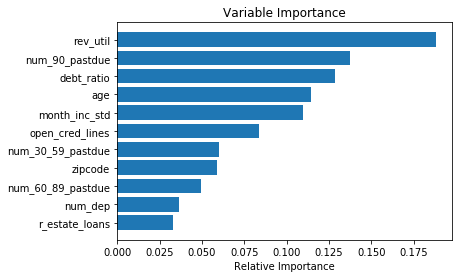

In [146]:
pot_features = np.array(['rev_util','age', 'zipcode',
       'num_30_59_pastdue', 'debt_ratio', 'month_inc_std', 'open_cred_lines',
       'num_90_pastdue', 'r_estate_loans', 'num_60_89_pastdue', 'num_dep'])

MLpipeline.plot_importances(df, pot_features, 'ser_DLq2')

Some (but not all!) of our previous findings and basic intuitions are reflected in the results above. In order not to overfit the classifier at the expense of its generalizability to future predictions, we will atempt to keep the minimal number of features such that they are still able to build an accurate model (these invloves trial and error and experience, so we will arbitraily keep the top six.

## 5. Build Classifier

Having selected some promising features, we will train a classifying algorithm to predict unobserved cases of possible delinquency.

First we will split our dataset into a testing and training set, choose our preferred model (among k-nearest neighbor (KNN) or decision tree (DT), build it with the training set, and fit it to the testing set.

In [155]:
features = ['ser_DLq2','rev_util','num_90_pastdue','open_cred_lines','debt_ratio','month_inc_std','age']

x_train, x_test, y_train, y_test = MLpipeline.split_dataset(df[features], 'ser_DLq2')
knn = MLpipeline.fit_classifier('KNN', x_train, y_train)
dt = MLpipeline.fit_classifier('DT', x_train, y_train)

## 6. Evaluate Classifier

For now we will measure our classifiers' performance by simply computing the proportion of correct predictions it made on the test set.

In [156]:
acc_KNN = MLpipeline.get_acc(knn, x_test, y_test)
acc_DT = MLpipeline.get_acc(dt, x_test, y_test)

In [157]:
acc_KNN, acc_DT

(0.8518488419341731, 0.867208451848842)

The decision tree does slightly better in terms of accuracy. However, more careful analysis is required to assess each of these algorithm's perfomance.